In [24]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import UnitaryGate
import numpy as np
import random

# Unitary matrices of functions

In [48]:
# n is the number of input qubits to the function
n = 4

####### ChatGPT generated #######
def generate_U_f(f, n):
    """Generate U_f unitary matrix for a Boolean function f: {0,1}^n -> {0,1}."""
    dim = 2 ** (n + 1)
    U_f = np.zeros((dim, dim), dtype=int)
    for i in range(dim):
        x = i >> 1         # Extract n-bit input x
        y = i & 1          # Extract 1-bit input y
        fx = f(x)
        y_out = y ^ fx     # Compute y ⊕ f(x)
        j = (x << 1) | y_out
        U_f[j, i] = 1
    return U_f

def generate_constant(n, value=None):
    """
    Generate a U_f matrix for a constant Boolean function f: {0,1}^n -> {0 or 1}.
    If `value` is None, randomly choose between 0 and 1.
    """
    if value is None:
        value = random.randint(0, 1)
    def f(x): return value
    return generate_U_f(f, n)


def generate_balanced(n):
    """Generate a U_f matrix for a balanced Boolean function f: {0,1}^n -> {0,1}."""
    num_inputs = 2 ** n
    ones_positions = set(random.sample(range(num_inputs), num_inputs // 2))
    def f(x): return int(x in ones_positions)
    return generate_U_f(f, n)

def generate_general(n, num_zeros=None):
    """
    Generate U_f for a general Boolean function f: {0,1}^n -> {0,1}.
    You can specify exactly how many inputs map to 0 (num_zeros).
    """
    num_inputs = 2 ** n

    if num_zeros is None:
        # Default: random distribution
        truth_table = [random.randint(0, 1) for _ in range(num_inputs)]
    else:
        if not (0 <= num_zeros <= num_inputs):
            raise ValueError(f"num_zeros must be between 0 and {num_inputs}")
        num_ones = num_inputs - num_zeros
        truth_table = [0] * num_zeros + [1] * num_ones
        random.shuffle(truth_table)  # Randomize input-to-output mapping

    # Print summary
    print(f"Generated general function: {truth_table.count(0)} inputs → 0, {truth_table.count(1)} inputs → 1")

    def f(x): return truth_table[x]

    return generate_U_f(f, n)
#################################################

U_f = generate_general(n, num_zeros=14)
print(U_f)

Generated general function: 14 inputs → 0, 2 inputs → 1
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


# Modelling and drawing the circuit

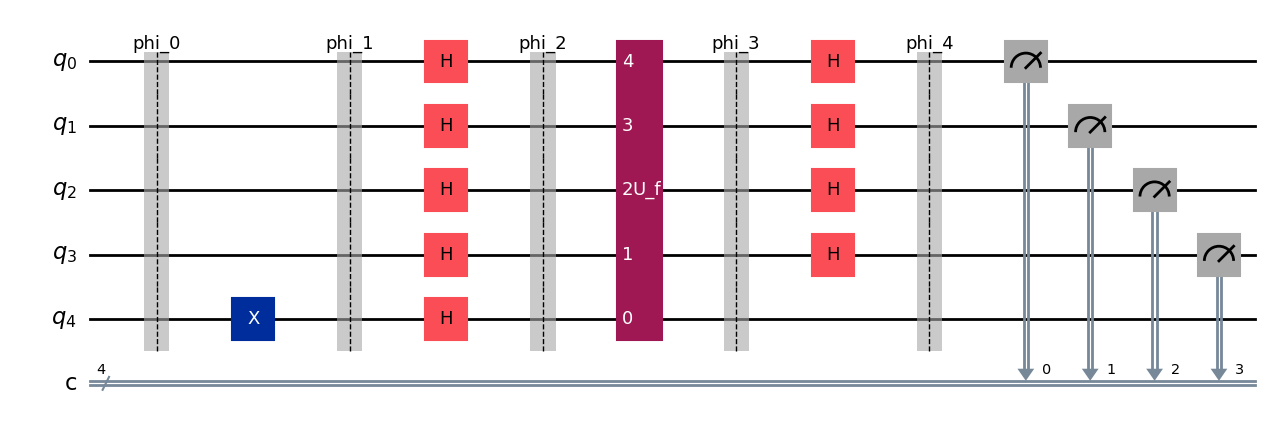

In [49]:
de = QuantumCircuit(n+1, n) # n+1 qubits, n measure bits
de.save_statevector(label="phi_0")

# Step 1: Flip bottom bit to ket 1
de.x(n)
de.save_statevector(label="phi_1")

# Step 2.1: Put the top bit through H_n (n tensor products)
de.h(range(n+1)) # for bottom qubit as well
de.save_statevector(label="phi_2")

# Step 3: Apply the unitary matrix representing the function f
U_f = UnitaryGate(U_f, label="U_f")
#U_f = UnitaryGate(U_f_balanced, label="U_f_balanced")
de.append(U_f, list(reversed(range(n+1))))
de.save_statevector(label="phi_3")

# Step 4: Put the top n bits through a hadamard matrix
de.h(range(n))
de.save_statevector(label="phi_4")

# Step 5: Measure the top qubit
for i in range(n):
    de.measure(i, i)


de.draw("mpl")

# Measurement

In [50]:
simulator = Aer.get_backend('aer_simulator')

# Transpile the circuit for the backend
compiled_circuit = transpile(de, simulator)

# Run the circuit
result = simulator.run(compiled_circuit, shots=100000).result()

# Get and print the counts
counts = result.get_counts()
print("Measurement results:", counts)


Measurement results: {'0001': 6193, '1111': 6352, '0111': 6293, '0110': 6292, '1110': 6279, '0000': 56200, '1000': 6247, '1001': 6144}
